# Graph SLAM Problem

$\min J(x_i) = x_0^T\Omega_0 x_0 + \sum_t e_t R_t^{-1} e_t  + \sum_t \sum_i \tilde{z}^i_t  Q_t^{-1} \tilde{z}^i_t \$

$ e_t \equiv x_t - g(u_t, x_{t-1})$ prediction error at time t

$\tilde{z}^i_t \equiv z^i_t - h(x_t, m^i_t)$ measurement error

$\dot{p_x} = v_x$

$\dot{p_y} = v_y$

$x_t = \begin{bmatrix} p_x \\ p_y \end{bmatrix}$
$u_t = \begin{bmatrix} v_x \\ v_y \end{bmatrix}$

$x_t = x_{t-1} + \Delta_t u_t $

$g(u_t, x_t{-1}) = x_{t-1}  + \Delta_t u_t$

Landmarks are points. And our measurement is relative position.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import casadi as ca
import slam2d

[[ 2.          1.57079633  0.        ]
 [ 2.82842712  2.35619449  1.        ]
 [ 3.20259425 -0.05503798  3.        ]
 [ 3.21409934  0.10092252  3.        ]
 [ 2.0242686  -0.70089855  4.        ]
 [ 1.74419124 -0.48001881  4.        ]
 [ 2.74447748 -1.51477816  5.        ]
 [ 2.2454363  -1.50231058  5.        ]]
[[ 2.          0.        ]
 [ 3.96013316  0.39733866]
 [ 5.80225514  1.17617535]
 [ 7.45292637  2.30546029]
 [ 8.84633979  3.74017247]
 [ 9.9269444   5.42311444]
 [10.65165991  7.28719262]
 [10.9915942   9.25809208]
 [10.93319515 11.25723928]
 [10.47879096 13.20493454]]


2.9836506698447058e-30

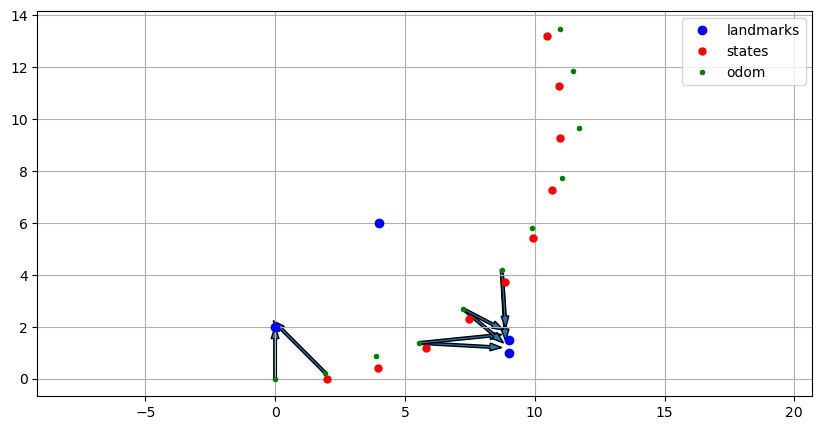

In [3]:
noise={
    'odom_std': .10,
    'bearing_std': 0,
    'range_std': 0,
    'odom_bx_bias': 0,
    'odom_by_bias': 0
}

plt.figure(figsize=(10, 5))

sim = slam2d.simulate(noise=noise, plot=True);

print(sim['hist']['z'])
print(sim['hist']['x'])

slam2d.J_graph_slam(sim['hist'], sim['x_odom_hist'], sim['landmarks'])

In [3]:
# data from sim
odom = sim['hist']['odom']
l = sim['landmarks']
z = sim['hist']['z']

# initialize x guess from odom
x0 = sim['hist']['x']
x1 = x0[:,0]
x2 = x0[:,1]
l1 = l[:,0]
l2 = l[:,1]
x0_new = np.hstack([x1, x2, l1, l2])

# compute data associations
assoc = [ slam2d.data_association(x0[int(xi), :], np.array([rng, bearing]), l) for rng, bearing, xi in z ]
assoc
# print(z)
# print()

# build cost
f_J, J = slam2d.build_cost(odom, z, assoc, x0.shape[0], l.shape[0])

# compute cost , this is where we will send it to casadi nonlinear optim
f_J(x0, l)

# Symbols/expressions
nlp = {}                 # NLP declaration
nlp['x']= ca.vertcat(f_J.sx_in()[0][:,0], f_J.sx_in()[0][:,1], f_J.sx_in()[1][:,0], f_J.sx_in()[1][:,1]) # decision vars
nlp['f'] = J           # objective
nlp['g'] = 0             # constraints

# Create solver instance
F = ca.nlpsol('F','ipopt',nlp);

# Solve the problem using a guess
# This uses original landmark/measure association (associates which landmark we think the measurement is measuring)
optim = F(x0=x0_new)
optim

# Re-associate landmark/measurements given new xstar positions


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       67

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

{'f': DM(0.200503),
 'g': DM(0),
 'lam_g': DM(-0),
 'lam_p': DM([]),
 'lam_x': DM([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'x': DM([2, 3.96013, 5.80226, 7.45293, 8.84944, 9.93005, 10.6548, 10.9947, 10.9363, 10.4819, -3.98136e-10, 0.397339, 1.17618, 2.30546, 3.74157, 5.42451, 7.28859, 9.25949, 11.2586, 13.2063, 3.20657e-10, 4, 9.00976, 9.01452, 2, 6, 1.24978, 1.25267])}

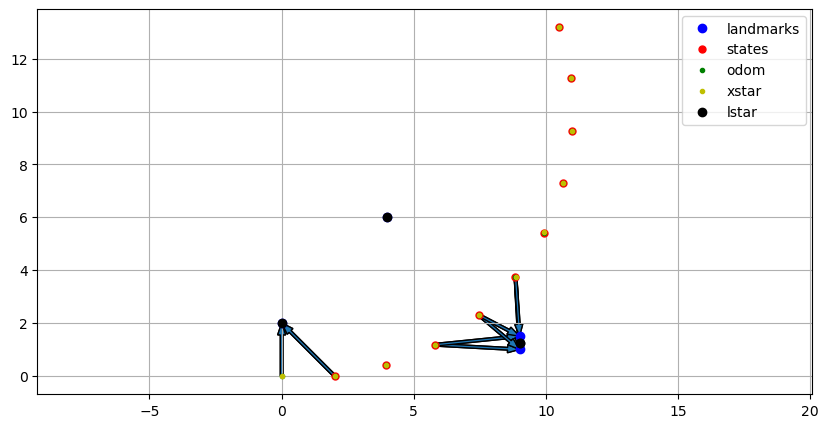

In [4]:
hist = sim['hist']
n_x = len(hist['x'])
n_l = len(sim['landmarks'])
xstar = np.zeros([n_x+1,2])
xstar[1: :] = np.reshape(optim['x'][0:2*n_x], [n_x,2], order='F')
lstar = np.reshape(optim['x'][2*n_x:None], [n_l,2], order='F')

plt.figure(figsize=(10, 5))

slam2d.plot_me(sim)
plt.plot(xstar[:, 0], xstar[:, 1], 'y.', linewidth=3, label='xstar')
plt.plot(lstar[:, 0], lstar[:, 1], 'ko', label='lstar')
for rng, bearing, xi in hist['z']:
    xi = int(xi)
    x = xstar[xi, :]
    plt.arrow(x[0], x[1], rng*np.cos(bearing) , rng*np.sin(bearing), width=0.1,
                  length_includes_head=True)
plt.legend()

In [5]:
np.random.rand(2)

array([0.60389214, 0.6884578 ])

In [7]:
xstar

array([[ 0.        ,  0.        ],
       [ 2.        ,  0.        ],
       [ 3.96013316,  0.39733866],
       [ 5.80225514,  1.17617535],
       [ 7.45292637,  2.30546029],
       [ 8.84633979,  3.74017247],
       [ 9.9269444 ,  5.42311444],
       [10.65165991,  7.28719262],
       [10.9915942 ,  9.25809208],
       [10.93319515, 11.25723928],
       [10.47879096, 13.20493454]])